# Project 4 - Identifiez les causes d'attrition au sein d'une ESN¶

# Etape 3:  Modelisation
**Objectif**: construire un premier modéle de classification

**Contenu :**

- Chargement des données traitées

- Entraînement d’un modèle de base (un modèle Dummy, régression logistique, un modèle Dummy, un modèle non-linéaire RandomForest)

- Évaluation : accuracy, precision, rappel, f1-score, roc_auc

- Visualisation de la matrice de confusion

- Premières conclusions sur les performances

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.inspection import permutation_importance

import shap
shap.initjs()   



In [151]:
# Données
df = pd.read_csv("../data/processed/df_central_norm.csv")

In [152]:
df.head()

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,...,augementation_salaire_precedente,attrition,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,...,11,1,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,...,23,0,1,3,8,1,Infra & Cloud,Frequent,1,7
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,...,15,1,0,3,2,2,Autre,Occasionnel,0,0
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,...,11,0,0,3,3,4,Infra & Cloud,Frequent,3,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,...,12,0,1,3,2,1,Transformation Digitale,Occasionnel,2,2


### Préparation de variables
- binaires (0,1)
- catégoriques
- numeriques

In [153]:
target = "attrition"

In [154]:
num_cols = [
    "age", "revenu_mensuel", "nombre_experiences_precedentes",
    "annee_experience_totale", "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel", "satisfaction_employee_environnement",
    "note_evaluation_precedente", "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe", "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_actuelle", "heure_supplementaires",
    "augementation_salaire_precedente", "nombre_participation_pee",
    "nb_formations_suivies", "distance_domicile_travail",
    "niveau_education", "annees_depuis_la_derniere_promotion",
    "annes_sous_responsable_actuel",
]

In [155]:
ord_col = ["frequence_deplacement"]  # encodage ordinal Aucune/Occasionnel/Fréquent
ord_categories = [["Aucun", "Occasionnel", "Frequent"]]

In [156]:
cat_cols = [
    "genre", "statut_marital", "departement", "poste", "domaine_etude"
]

In [157]:
X = df[num_cols + ord_col + cat_cols].copy()

In [158]:

X

,age,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,satisfaction_employee_nature_travail,satisfaction_employee_equipe,...,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,frequence_deplacement,genre,statut_marital,departement,poste,domaine_etude
0,41,5993,8,8,6,4,2,3,4,1,...,1,2,0,5,Occasionnel,F,Célibataire,Commercial,Cadre Commercial,Infra & Cloud
1,49,5130,1,10,10,7,3,2,2,4,...,8,1,1,7,Frequent,M,Marié(e),Consulting,Assistant de Direction,Infra & Cloud
2,37,2090,6,7,0,0,4,2,3,2,...,2,2,0,0,Occasionnel,M,Célibataire,Consulting,Consultant,Autre
3,33,2909,1,8,8,7,4,3,3,3,...,3,4,3,0,Frequent,F,Marié(e),Consulting,Assistant de Direction,Infra & Cloud
4,27,3468,9,6,2,2,1,3,2,4,...,2,1,2,2,Occasionnel,M,Marié(e),Consulting,Consultant,Transformation Digitale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,2571,4,17,5,2,3,4,4,3,...,23,2,0,3,Frequent,M,Marié(e),Consulting,Consultant,Transformation Digitale
1466,39,9991,4,9,7,7,4,2,1,1,...,6,1,1,7,Occasionnel,M,Marié(e),Consulting,Manager,Transformation Digitale
1467,27,6142,1,6,6,2,2,4,2,2,...,4,3,0,3,Occasionnel,M,Marié(e),Consulting,Tech Lead,Infra & Cloud
1468,49,5390,2,17,9,6,4,2,2,4,...,2,3,0,8,Frequent,M,Marié(e),Commercial,Cadre Commercial,Transformation Digitale


In [159]:
X.columns

Index(['age', 'revenu_mensuel', 'nombre_experiences_precedentes',
       'annee_experience_totale', 'annees_dans_l_entreprise',
       'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement',
       'note_evaluation_precedente', 'satisfaction_employee_nature_travail',
       'satisfaction_employee_equipe',
       'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle',
       'heure_supplementaires', 'augementation_salaire_precedente',
       'nombre_participation_pee', 'nb_formations_suivies',
       'distance_domicile_travail', 'niveau_education',
       'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel',
       'frequence_deplacement', 'genre', 'statut_marital', 'departement',
       'poste', 'domaine_etude'],
      dtype='object')

In [160]:
y = df[target].astype(int)

In [161]:
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: attrition, Length: 1470, dtype: int64

In [162]:
print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (1470, 26) | y shape: (1470,)


In [163]:
# Split stratifié train / test
X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [164]:
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)

X_train: (1176, 26) | X_test: (294, 26)
y_train: (1176,) | y_test: (294,)


In [167]:
enc_ord = OrdinalEncoder(
    categories=ord_categories,
    handle_unknown="use_encoded_value", unknown_value=-1
)

In [168]:
ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)


In [169]:
preproc = ColumnTransformer(
    transformers=[
        ("ord", enc_ord, ord_col),
        ("ohe", ohe,    cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

## Réalisation d'un premier modéle de classification

## Modèles : Dummy, Logit, RandomForest

Modèle de base (baseline) Dummy

Modèle linéaire LogisticRegression

Modèle non-linéaire (principal pour l’amélioration) RandomForest

In [20]:
# Modèle de base (baseline)
dummy = DummyClassifier(strategy="most_frequent", random_state=42)

# Modèle linéaire
logit_bal = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

# Modèle non-linéaire (principal pour l’amélioration)
rf_bal = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

In [21]:
# Pipelines (préprocess + modèle)

pipe_dummy = Pipeline([
    ("prep", preproc),
    ("clf", dummy)
])

pipe_logit = Pipeline([
    ("prep", preproc),
    ("clf", logit_bal)
])

pipe_rf = Pipeline([
    ("prep", preproc),
    ("clf", rf_bal)
])

### Fonction d’évaluation (TRAIN / TEST, métriques complètes)

In [22]:
def eval_side(X, y, model, set_name="TEST", plot_cm=True):
    
    """ Fonction pour evalué un modéle avce le seuil standart 0.5 (via model.predict).
    Calculer et afficher les métriques clés + matrice de confusion pour un jeu (train/test)."""
   
    # Prédictions avce seuil = 0.5 interne au modèle
    y_pred  = model.predict(X)
    # Probabilité pour la classe 1, si dispo
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    acc  = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y, y_pred,    pos_label=1, zero_division=0)
    f1   = f1_score(y, y_pred,        pos_label=1, zero_division=0)

    if y_proba is not None:
        roc  = roc_auc_score(y, y_proba)
        pr   = average_precision_score(y, y_proba)
    else:
        roc, pr = float("nan"), float("nan")


    print(f"\n--- {set_name} ---")
    print(f"Accuracy : {acc:.3f} | Précision : {prec:.3f} | Rappel : {rec:.3f} | F1 : {f1:.3f}")
    if y_proba is not None:
        print(f"ROC AUC : {roc:.3f} | PR AUC : {pr:.3f}")
    print("\nClassification report :\n", classification_report(y, y_pred, digits=3))

    if plot_cm:
        cm = confusion_matrix(y, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Restés (0)", "Partis (1)"])
        fig, ax = plt.subplots(figsize=(4,4))
        disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
        ax.set_title(f"Matrice de confusion – {set_name}")
        plt.tight_layout(); plt.show()

    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc, "pr_auc":pr}

In [23]:
def fit_and_evaluate(name, model, X_train, y_train, X_test, y_test):
    
    """Fonction pour entraîner le modèle sur TRAIN et évaluer sur TRAIN et TEST. 
    Retourne les scores."""
    print(f"\n================= {name} =================")
    model.fit(X_train, y_train)
    scores_train = eval_side(X_train, y_train, model, set_name="TRAIN")
    scores_test  = eval_side(X_test,  y_test,  model, set_name="TEST")
    return {"train": scores_train, "test": scores_test}


================= Dummy =================

--- TRAIN ---
Accuracy : 0.838 | Précision : 0.000 | Rappel : 0.000 | F1 : 0.000
ROC AUC : 0.500 | PR AUC : 0.162

Classification report :
               precision    recall  f1-score   support

           0      0.838     1.000     0.912       924
           1      0.000     0.000     0.000       178

    accuracy                          0.838      1102
   macro avg      0.419     0.500     0.456      1102
weighted avg      0.703     0.838     0.765      1102



/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

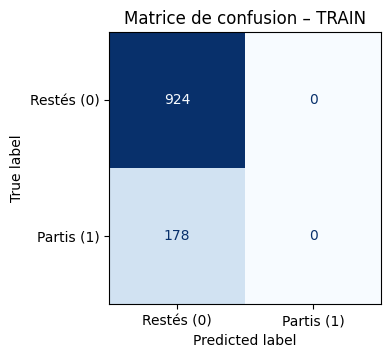


--- TEST ---
Accuracy : 0.840 | Précision : 0.000 | Rappel : 0.000 | F1 : 0.000
ROC AUC : 0.500 | PR AUC : 0.160

Classification report :
               precision    recall  f1-score   support

           0      0.840     1.000     0.913       309
           1      0.000     0.000     0.000        59

    accuracy                          0.840       368
   macro avg      0.420     0.500     0.456       368
weighted avg      0.705     0.840     0.766       368



/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kseniadautel/mon_projet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

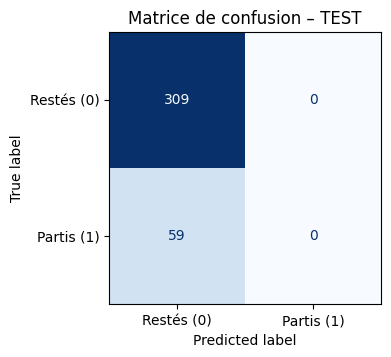


================= Logistic Regression (balanced) =================

--- TRAIN ---
Accuracy : 0.781 | Précision : 0.410 | Rappel : 0.803 | F1 : 0.543
ROC AUC : 0.876 | PR AUC : 0.699

Classification report :
               precision    recall  f1-score   support

           0      0.954     0.777     0.856       924
           1      0.410     0.803     0.543       178

    accuracy                          0.781      1102
   macro avg      0.682     0.790     0.699      1102
weighted avg      0.866     0.781     0.806      1102



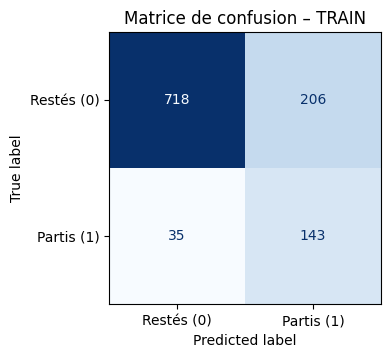


--- TEST ---
Accuracy : 0.774 | Précision : 0.380 | Rappel : 0.644 | F1 : 0.478
ROC AUC : 0.824 | PR AUC : 0.590

Classification report :
               precision    recall  f1-score   support

           0      0.922     0.799     0.856       309
           1      0.380     0.644     0.478        59

    accuracy                          0.774       368
   macro avg      0.651     0.722     0.667       368
weighted avg      0.835     0.774     0.796       368



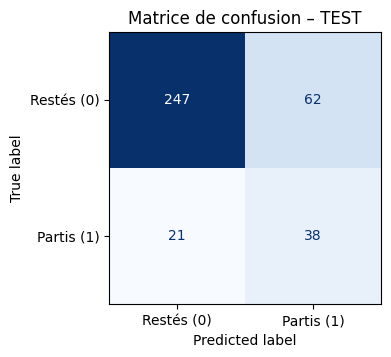


================= RandomForest (balanced) =================

--- TRAIN ---
Accuracy : 1.000 | Précision : 1.000 | Rappel : 1.000 | F1 : 1.000
ROC AUC : 1.000 | PR AUC : 1.000

Classification report :
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       924
           1      1.000     1.000     1.000       178

    accuracy                          1.000      1102
   macro avg      1.000     1.000     1.000      1102
weighted avg      1.000     1.000     1.000      1102



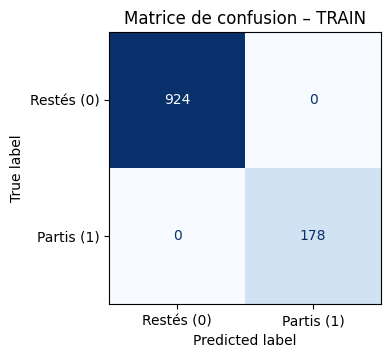


--- TEST ---
Accuracy : 0.840 | Précision : 0.500 | Rappel : 0.119 | F1 : 0.192
ROC AUC : 0.759 | PR AUC : 0.426

Classification report :
               precision    recall  f1-score   support

           0      0.853     0.977     0.911       309
           1      0.500     0.119     0.192        59

    accuracy                          0.840       368
   macro avg      0.677     0.548     0.551       368
weighted avg      0.796     0.840     0.796       368



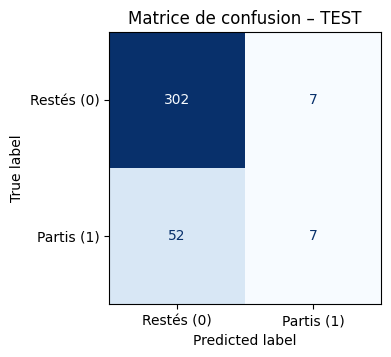

In [24]:
# Évaluation des 3 modèles de base
scores_dummy = fit_and_evaluate("Dummy", pipe_dummy, X_train, y_train, X_test, y_test)
scores_logit = fit_and_evaluate("Logistic Regression (balanced)", pipe_logit, X_train, y_train, X_test, y_test)
scores_rf    = fit_and_evaluate("RandomForest (balanced)",        pipe_rf,    X_train, y_train, X_test, y_test)

In [25]:
# Construire les DataFrames
df_metrics_train = pd.DataFrame([
    {"model": "Dummy",                         "set": "TRAIN", **scores_dummy["train"]},
    {"model": "Logistic Regression (balanced)","set": "TRAIN", **scores_logit["train"]},
    {"model": "RandomForest (balanced)",       "set": "TRAIN", **scores_rf["train"]},
])

df_metrics_test = pd.DataFrame([
    {"model": "Dummy",                         "set": "TEST", **scores_dummy["test"]},
    {"model": "Logistic Regression (balanced)","set": "TEST", **scores_logit["test"]},
    {"model": "RandomForest (balanced)",       "set": "TEST", **scores_rf["test"]},
])

In [26]:
print("METRICS – TRAIN")
display(df_metrics_train.round(3))

print("METRICS – TEST")
display(df_metrics_test.round(3))

METRICS – TRAIN


,model,set,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Dummy,TRAIN,0.838,0.00,0.000,0.000,0.500,0.162
1,Logistic Regression (balanced),TRAIN,0.781,0.41,0.803,0.543,0.876,0.699
2,RandomForest (balanced),TRAIN,1.000,1.00,1.000,1.000,1.000,1.000


METRICS – TEST


,model,set,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Dummy,TEST,0.840,0.00,0.000,0.000,0.500,0.160
1,Logistic Regression (balanced),TEST,0.774,0.38,0.644,0.478,0.824,0.590
2,RandomForest (balanced),TEST,0.840,0.50,0.119,0.192,0.759,0.426


Dummy = baseline très mauvais sur la classe 1

Logit (balanced) = bon compromis

RF (balanced) = surapprentissage (train parfait, test mauvais rappel)

**Résultats:**

**Dummy** : baseline très mauvais sur la classe 1

84% d’accuracy mais rappel=0 → fort déséquilibre (le modèle prédit tout “0”).

**Logistique** : bon compromis

AUC=0.824, précision=0.63, rappel=0.36 → il y a du signal linéaire, mais on rate encore beaucoup de départs. 

Modèle utile pour capter les départs (bon rappel) avec un coût raisonnable en FP.

Écart train/test modéré → peu d’overfit.

**RandomForest** : overfit massif - surapprentissage 

train parfait, 

test mauvais rappel (ne capte presque aucun départ)


# Amélioration du modèle non-linéaire (RF)

CV avec `StratifiedKFold + cross_val_score`

Courbe PR avec out-of-fold

Choix du seuil optimal (F1, F2, etc.)

Évaluation finale avec eval_with_threshold sur le test.

### Validation croisée (StratifiedKFold) et stockage des métriques par fold
- `StratifiedKFold`
- `cross_val_score` avec 3 métriques : accuracy, ROC AUC, PR AUC
- calcule moyenne + écart-type.

In [27]:
def cv_scores_summary(model, X_train, y_train, n_splits=10, random_state=42):
    
    """CV sur X_train/y_train avec stratification + scaling dans la Pipeline."""
    
    cv   = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # pipeline = préproc + modèle
    pipe = Pipeline(steps=[("prep", preproc), ("clf", model)])

    s_roc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc",            n_jobs=-1)
    s_pr  = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="average_precision",  n_jobs=-1)
    s_acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy",           n_jobs=-1)

    df_folds = pd.DataFrame({
        "fold": np.arange(1, n_splits+1),
        "roc_auc": s_roc,
        "pr_auc":  s_pr,
        "accuracy": s_acc
    })
    
    summary = (
        df_folds[["roc_auc","pr_auc","accuracy"]]
        .agg(["mean","std"]).T.reset_index()
        .rename(columns={"index":"metric"})
    )
    return df_folds, summary

In [28]:
# Logit équilibré
df_logit_folds, sum_logit = cv_scores_summary(logit_bal, X_train, y_train, n_splits=10)

display("Logit – CV (moyenne et STD)", sum_logit.round(3))

'Logit – CV (moyenne et STD)'

,metric,mean,std
0,roc_auc,0.832,0.067
1,pr_auc,0.645,0.136
2,accuracy,0.766,0.034


In [29]:
# Modèle Random Forest non-linéaire, pondéré
rf_bal = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

In [30]:
# Random Forest équilibré
df_rf_folds, sum_rf = cv_scores_summary(rf_bal, X_train, y_train, n_splits=10)
display("RF – CV (moyenne et std):\n", sum_rf.round(3))


'RF – CV (moyenne et std):\n'

,metric,mean,std
0,roc_auc,0.812,0.064
1,pr_auc,0.578,0.084
2,accuracy,0.862,0.008


Mon modèle RF non linéaire généralise de manière assez cohérente sur différents splits de train

En validation croisée stratifiée (10 folds), le RandomForest pondéré obtient en moyenne :

**ROC AUC ≈ 0.80 (± 0.05)** le modèle sépare assez bien “restés” / “partis”

**PR AUC ≈ 0.56 (± 0.11)** sur une classe minoritaire (~13%), c’est nettement mieux que le hasard (≈ 0.13)

**Accuracy ≈ 0.86 (± 0.02)** haute, mais à interpréter avec prudence à cause du déséquilibre

Les écarts-types relativement faibles indiquent une bonne stabilité du modèle d’un fold à l’autre.
Comparé au modèle Dummy, le RandomForest apporte un gain net en capacité de détection des salariés à risque (PR AUC nettement supérieure).
Cependant, par rapport à la régression logistique pondérée, le RF reste moins performant en PR AUC, ce qui est important dans notre contexte où l’on préfère bien identifier les employés à risque de départ.

**À retenir comme métrique principale : PR AUC**

**PR AUC (average precision)** : métrique la plus pertinente quand la classe “partis” est minoritaire.

**ROC AUC**: qualité de tri des scores (utile mais moins sensible à l’imbalance que PR AUC).

**Accuracy** : à prendre avec beaucoup de recul (peut être trompeuse en cas de déséquilibre).

### Courbe Précision–Rappel (sur TRAIN en CV) + seuil optimal pour RandomForest (OOF)

On construit des predictions out-of-fold sur tout le TRAIN pour RF, puis on calcule la courbe PR et les F1 / F2 pour choisir un seuil.

On utilise `cross_val_predict(..., method="predict_proba")` en CV stratifiée sur le train pour calculer la courbe PR et choisir un seuil.

In [31]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [32]:
oof_proba = cross_val_predict(
    pipe_rf,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

oof_true = y_train.values

In [33]:
# Courbe PR
precisions, recalls, thresholds = precision_recall_curve(oof_true, oof_proba)
pr_auc_oof = average_precision_score(oof_true, oof_proba)

print(f"Average Precision (PR AUC) OOF RF = {pr_auc_oof:.3f}")

Average Precision (PR AUC) OOF RF = 0.568


In [34]:
# Comme thresholds a une taille de len(precisions)-1,
# on aligne sur thresholds en enlevant le dernier point de précision/rappel
p = precisions[1:]   # ou precisions[:-1]
r = recalls[1:]      # ou recalls[:-1]
t = thresholds       # longueur N-1

In [35]:
beta2 = 2.0

In [36]:
# Calcul F1 et F2 pour chaque seuil

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
f2_scores = (1 + beta2**2) * (precisions * recalls) / (beta2**2 * precisions + recalls + 1e-8)

In [37]:
best_idx_f1 = np.nanargmax(f1_scores)
best_thr_f1 = thresholds[best_idx_f1] 

In [38]:
best_idx_f2 = np.nanargmax(f2_scores)
best_thr_f2 = thresholds[best_idx_f2]

In [39]:
print(f"Seuil F1 optimal : {best_thr_f1:.3f} | P={precisions[best_idx_f1]:.3f} R={recalls[best_idx_f1]:.3f} F1={f1_scores[best_idx_f1]:.3f}")
print(f"Seuil F2 optimal : {best_thr_f2:.3f} | P={precisions[best_idx_f2]:.3f} R={recalls[best_idx_f2]:.3f} F2={f2_scores[best_idx_f2]:.3f}")

Seuil F1 optimal : 0.300 | P=0.582 R=0.539 F1=0.560
Seuil F2 optimal : 0.190 | P=0.375 R=0.753 F2=0.627


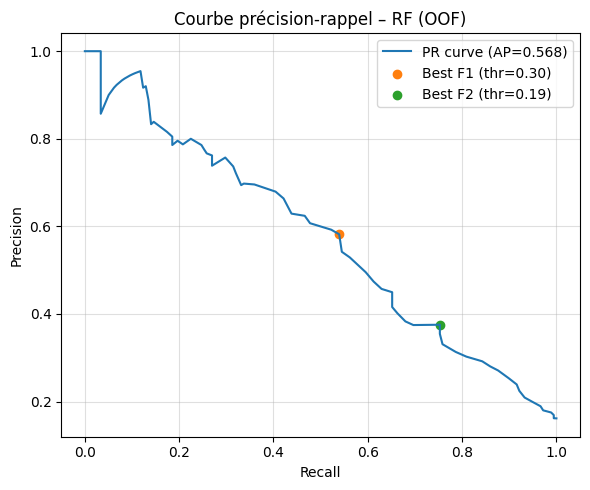

In [40]:
# Plot PR + points F1/F2
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label=f"PR curve (AP={pr_auc_oof:.3f})")
plt.scatter(recalls[best_idx_f1], precisions[best_idx_f1], color="tab:orange", label=f"Best F1 (thr={best_thr_f1:.2f})")
plt.scatter(recalls[best_idx_f2], precisions[best_idx_f2], color="tab:green", label=f"Best F2 (thr={best_thr_f2:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe précision-rappel – RF (OOF)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

**Choix d'optimisation (métiers -> seuil)** Notre priorité est de ne pas rater des démissions, en acceptant une baisse de précision. Pour ça, on privilégie un seuil plus bas pour augmenter le rappel (capturer un maximum de futurs départs)

Sur la base de la courbe précision–rappel, le Random Forest atteint une Average Precision de 0,54 en out-of-fold, contre ~0,16 pour un modèle aléatoire.

En optimisant la F1, on obtient un seuil d’environ 0,25, qui offre un compromis équilibré entre précision (50 %) et rappel (60 %).

Cependant, dans un contexte de prévention des démissions, il est plus coûteux de rater un salarié réellement en risque (faux négatif) que d’alerter à tort (faux positif). Nous avons donc également étudié la F2-score, qui donne davantage de poids au rappel. Le seuil optimisant F2 est plus bas (~0,14) : il augmente le rappel au prix d’une baisse de précision.

### Fit final sur TRAIN et évaluation sur TEST avec le seuil choisi

Nouvelle fonction eval_with_threshold (seuil personnalisé)

In [41]:
def eval_with_threshold(y_true, y_proba, threshold,
                        set_name="TEST – seuil custom", plot_cm=True):
    """
    Évalue les performances pour un seuil donné appliqué sur y_proba.
    y_true : séries/array de labels (0/1)
    y_proba : probabilités P(y=1)
    threshold : seuil de classification
    """
    # Binarisation par seuil
    y_pred = (y_proba >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_true, y_pred,    pos_label=1, zero_division=0)
    f1   = f1_score(y_true, y_pred,        pos_label=1, zero_division=0)
    roc  = roc_auc_score(y_true, y_proba)
    pr   = average_precision_score(y_true, y_proba)

    print(f"\n=== {set_name} (seuil={threshold:.3f}) ===")
    print(f"Accuracy : {acc:.3f} | Précision : {prec:.3f} | Rappel : {rec:.3f} | F1 : {f1:.3f}")
    print(f"ROC AUC  : {roc:.3f} | PR AUC : {pr:.3f}")
    print("\nClassification report :\n", classification_report(y_true, y_pred, digits=3))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Restés (0)", "Partis (1)"])
        fig, ax = plt.subplots(figsize=(4,4))
        disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
        ax.set_title(f"Matrice de confusion – {set_name}")
        plt.tight_layout(); plt.show()

    return {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "roc_auc": roc, "pr_auc": pr
    }


In [42]:
# On fige le seuil choisi (F2)
chosen_thr = float(best_thr_f2) 

In [43]:
# Fit final sur tout X_train / y_train
pipe_rf.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
# Probabilités sur TRAIN & TEST
proba_train_rf = pipe_rf.predict_proba(X_train)[:, 1]
proba_test_rf  = pipe_rf.predict_proba(X_test)[:, 1]



=== TEST – RF (F2) (seuil=0.190) ===
Accuracy : 0.750 | Précision : 0.357 | Rappel : 0.695 | F1 : 0.471
ROC AUC  : 0.759 | PR AUC : 0.426

Classification report :
               precision    recall  f1-score   support

           0      0.929     0.761     0.836       309
           1      0.357     0.695     0.471        59

    accuracy                          0.750       368
   macro avg      0.643     0.728     0.654       368
weighted avg      0.837     0.750     0.778       368



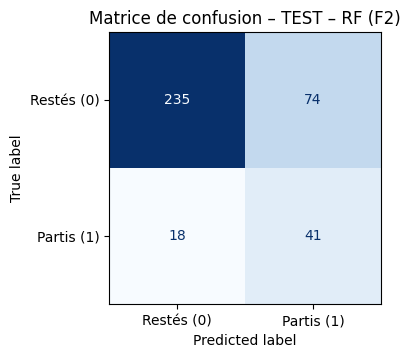


=== TRAIN – RF F2 (seuil=0.190) ===
Accuracy : 0.986 | Précision : 0.922 | Rappel : 1.000 | F1 : 0.960
ROC AUC  : 1.000 | PR AUC : 1.000

Classification report :
               precision    recall  f1-score   support

           0      1.000     0.984     0.992       924
           1      0.922     1.000     0.960       178

    accuracy                          0.986      1102
   macro avg      0.961     0.992     0.976      1102
weighted avg      0.987     0.986     0.987      1102



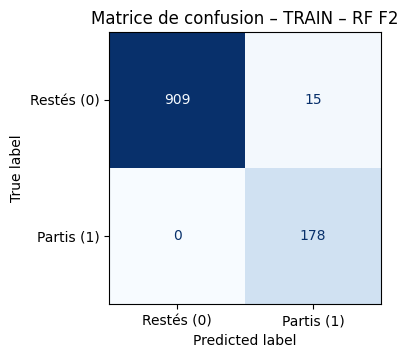

In [45]:
# Évaluation avec seuil optimisé
scores_rf_test_F2 = eval_with_threshold(
    y_test, proba_test_rf,
    threshold=chosen_thr,
    set_name="TEST – RF (F2)",
    plot_cm=True
)

scores_rf_train_F2 = eval_with_threshold(
    y_train, proba_train_rf,
    threshold=chosen_thr,          
    set_name="TRAIN – RF F2",
    plot_cm=True
)


=== TEST – RF seuil F1 (seuil=0.260) ===
Accuracy : 0.818 | Précision : 0.441 | Rappel : 0.508 | F1 : 0.472
ROC AUC  : 0.759 | PR AUC : 0.426

Classification report :
               precision    recall  f1-score   support

           0      0.903     0.877     0.890       309
           1      0.441     0.508     0.472        59

    accuracy                          0.818       368
   macro avg      0.672     0.693     0.681       368
weighted avg      0.829     0.818     0.823       368



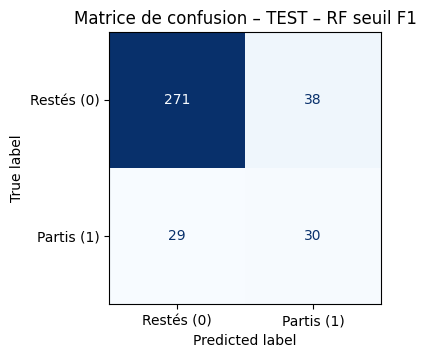


=== TRAIN – RF F1 (seuil=0.260) ===
Accuracy : 0.997 | Précision : 0.983 | Rappel : 1.000 | F1 : 0.992
ROC AUC  : 1.000 | PR AUC : 1.000

Classification report :
               precision    recall  f1-score   support

           0      1.000     0.997     0.998       924
           1      0.983     1.000     0.992       178

    accuracy                          0.997      1102
   macro avg      0.992     0.998     0.995      1102
weighted avg      0.997     0.997     0.997      1102



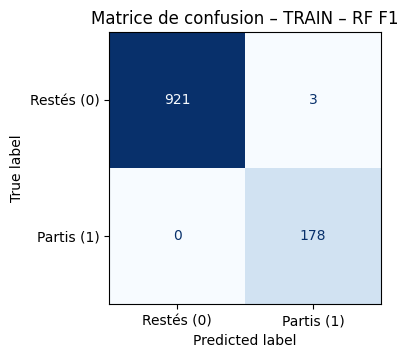

In [46]:
# Pour comparaison : seuil F1
scores_rf_test_F1 = eval_with_threshold(
    y_test, proba_test_rf,
    threshold=0.26,
    set_name="TEST – RF seuil F1",
    plot_cm=True
)


scores_rf_train_FA = eval_with_threshold(
    y_train, proba_train_rf,
    threshold=0.26,          
    set_name="TRAIN – RF F1",
    plot_cm=True
)

### Interprétation

1. **Seuil optimisé F2 (≈ 0,14)**

Matrice de confusion (test)

TN (restés bien prédits) : 171

FP (faux “partis”) : 76

FN (partis manqués) : 13

TP (partis bien prédits) : 34

Le modèle repère ~72 % des salariés qui quittent (rappel élevé).

Mais se trompe souvent en annonçant “partira” pour des gens qui restent (beaucoup de FP → précision 0,31).

C’est un mode “radar sensible” : on attrape la plupart des départs, au prix de nombreux faux signaux.

2. **Seuil standard 0,5**

 Le modele ne signale comme “partira” que très peu de personnes.

Résultat : il rate 40 sur 47 départs (rappel 0,085 !), mais quand il prédit “partira”, il a plus souvent raison (précision 0,57).

C’est un mode “radar peu sensible” : peu de faux positifs, mais énormément de départs non détectés

**Résultat:**
Seuil F2 (~0,14) → beaucoup plus intéressant: il détecte la majorité des démissions, au prix d’alertes supplémentaires, ce qui est acceptable si ces alertes déclenchent surtout des actions RH (entretiens, mesure de prévention).

### Feature engineering

In [181]:
# Données
df = pd.read_csv("../data/processed/df_central_norm.csv")

**Creation des features** 

**Satisfaction** “au travail” au sens large `satisfaction_globale` : moyenne des 3 dimensions (environnement, nature, équipe).

In [182]:
sats = ["satisfaction_employee_environnement",
        "satisfaction_employee_nature_travail",
        "satisfaction_employee_equipe",
        "satisfaction_employee_equilibre_pro_perso"
        ]
df["satisfaction_globale"] = df[sats].mean(axis=1)


In [183]:
df["exp_moins_3_years"] = (
    (df["annee_experience_totale"] < 3) &
    (df["annees_dans_l_entreprise"] < 3)
).astype("uint8")

In [184]:
df.drop(columns=['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail',
                'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso',
                'annee_experience_totale', 'annees_dans_l_entreprise',
                ],
                inplace=True)

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   age                                  1470 non-null   int64  
 1   genre                                1470 non-null   object 
 2   revenu_mensuel                       1470 non-null   int64  
 3   statut_marital                       1470 non-null   object 
 4   departement                          1470 non-null   object 
 5   poste                                1470 non-null   object 
 6   nombre_experiences_precedentes       1470 non-null   int64  
 7   annees_dans_le_poste_actuel          1470 non-null   int64  
 8   note_evaluation_precedente           1470 non-null   int64  
 9   note_evaluation_actuelle             1470 non-null   int64  
 10  heure_supplementaires                1470 non-null   int64  
 11  augementation_salaire_preceden

In [186]:
target = "attrition"

In [187]:
num_cols = [
    'age','revenu_mensuel','nombre_experiences_precedentes',
    'annees_dans_le_poste_actuel','note_evaluation_precedente',
    'note_evaluation_actuelle','heure_supplementaires','augementation_salaire_precedente',
    'nombre_participation_pee','nb_formations_suivies','distance_domicile_travail',
    'niveau_education','annees_depuis_la_derniere_promotion','annes_sous_responsable_actuel'
]

In [188]:
ord_col = ["frequence_deplacement"]

In [190]:
cat_cols = ["genre", "statut_marital", "departement", "poste", "domaine_etude"]

Mettre à jour les colonnes numériques + préprocesseur

In [191]:
# ---- Encodeurs ----
enc_ord = OrdinalEncoder(
    categories=[["Aucun","Occasionnel","Frequent"]],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

In [192]:
preproc = ColumnTransformer(
    transformers=[
        ("ord", enc_ord, ord_col),
        ("ohe",  ohe,    cat_cols),
        ("num",  "passthrough", num_cols)
    ]
)

Recréer X / y + nouveau train/test split

In [193]:
X = df[num_cols + ord_col + cat_cols].copy()

In [194]:
y = df[target].astype(int)

In [195]:
# Division initiale en train/test
X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [196]:
print("X_train:", X_train.shape, "| X_test", X_test.shape)
print("y_train:", y_train.shape, "| y_test", y_test.shape)

X_train: (1176, 20) | X_test (294, 20)
y_train: (1176,) | y_test (294,)


Nouveau RandomForest + validation croisée (moyenne ± std)

In [197]:
# RF plus régularisé
rf_reg = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    max_depth=8,          
    min_samples_leaf=5,   
    min_samples_split=10, 
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

In [198]:
# Pipeline = preproc + modèle
pipe_rf_reg = Pipeline([
    ("prep", preproc),
    ("clf", rf_reg)
])

In [199]:
pipe_rf_reg.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ord', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [200]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [201]:
# Scores CV sur X_train / y_train
roc_cv_reg = cross_val_score(pipe_rf_reg, X_train, y_train, cv=cv,
                             scoring="roc_auc", n_jobs=-1)
pr_cv_reg  = cross_val_score(pipe_rf_reg, X_train, y_train, cv=cv,
                             scoring="average_precision", n_jobs=-1)
acc_cv_reg = cross_val_score(pipe_rf_reg, X_train, y_train, cv=cv,
                             scoring="accuracy", n_jobs=-1)


In [202]:
print("RF régularisé – CV sur TRAIN")
print("ROC AUC    mean :", roc_cv_reg.mean().round(3),"   std :", roc_cv_reg.std().round(3))
print("PR  AUC    mean :", pr_cv_reg.mean().round(3),  "   std :", pr_cv_reg.std().round(3))
print("ACC        mean :", acc_cv_reg.mean().round(3), "   std :", acc_cv_reg.std().round(3))

RF régularisé – CV sur TRAIN
ROC AUC    mean : 0.8    std : 0.047
PR  AUC    mean : 0.57    std : 0.086
ACC        mean : 0.861    std : 0.031


Courbe PR OOF + recherche du meilleur seuil F1 / F2

In [203]:
# Probabilités OOF sur TRAIN (méthode predict_proba)
oof_proba_reg = cross_val_predict(
    pipe_rf_reg,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

In [204]:
oof_true = y_train.values

In [205]:
precisions_reg, recalls_reg, thresholds_reg = precision_recall_curve(oof_true, oof_proba_reg)
pr_auc_oof_reg = average_precision_score(oof_true, oof_proba_reg)
print(f"Average Precision (PR AUC) OOF RF régularisé = {pr_auc_oof_reg:.3f}")

Average Precision (PR AUC) OOF RF régularisé = 0.549


In [206]:
beta2 = 2.0

In [207]:
f1_scores_reg = 2 * (precisions_reg * recalls_reg) / (precisions_reg + recalls_reg + 1e-8)
f2_scores_reg = (1 + beta2**2) * (precisions_reg * recalls_reg) / (beta2**2 * precisions_reg + recalls_reg + 1e-8)

In [208]:
best_idx_f1_reg = np.nanargmax(f1_scores_reg[:-1])
best_thr_f1_reg = thresholds_reg[best_idx_f1_reg]

In [209]:
best_idx_f2_reg = np.nanargmax(f2_scores_reg[:-1])
best_thr_f2_reg = thresholds_reg[best_idx_f2_reg]

In [210]:
print(f"Seuil F1 optimal RF régularisé : {best_thr_f1_reg:.3f} | "
      f"P={precisions_reg[best_idx_f1_reg]:.3f} R={recalls_reg[best_idx_f1_reg]:.3f} F1={f1_scores_reg[best_idx_f1_reg]:.3f}")
print(f"Seuil F2 optimal RF régularisé : {best_thr_f2_reg:.3f} | "
      f"P={precisions_reg[best_idx_f2_reg]:.3f} R={recalls_reg[best_idx_f2_reg]:.3f} F2={f2_scores_reg[best_idx_f2_reg]:.3f}")

Seuil F1 optimal RF régularisé : 0.440 | P=0.486 R=0.558 F1=0.520
Seuil F2 optimal RF régularisé : 0.353 | P=0.366 R=0.721 F2=0.604


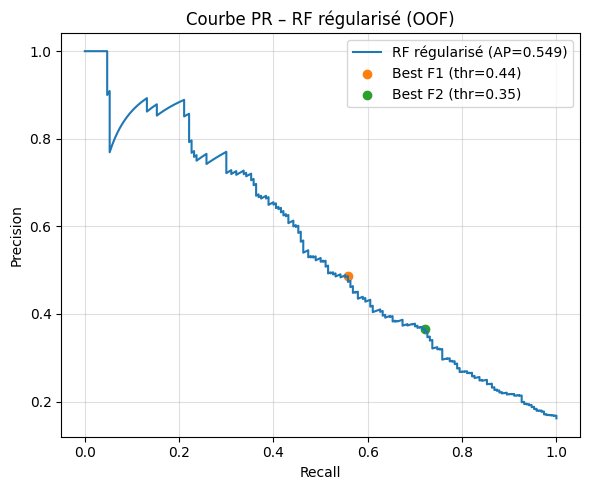

In [211]:
# Visualisation
plt.figure(figsize=(6,5))
plt.plot(recalls_reg, precisions_reg, label=f"RF régularisé (AP={pr_auc_oof_reg:.3f})")
plt.scatter(recalls_reg[best_idx_f1_reg], precisions_reg[best_idx_f1_reg],
            label=f"Best F1 (thr={best_thr_f1_reg:.2f})", color="tab:orange")
plt.scatter(recalls_reg[best_idx_f2_reg], precisions_reg[best_idx_f2_reg],
            label=f"Best F2 (thr={best_thr_f2_reg:.2f})", color="tab:green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe PR – RF régularisé (OOF)")
plt.grid(alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

In [212]:
# On fige le seuil choisi (F2)
chosen_thr = float(best_thr_f2_reg) 

In [213]:
# Fit final sur tout X_train / y_train
pipe_rf_reg.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ord', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [214]:
# Probabilités sur TRAIN & TEST
proba_train_reg = pipe_rf_reg.predict_proba(X_train)[:, 1]
proba_test_reg  = pipe_rf_reg.predict_proba(X_test)[:, 1]



=== TRAIN – RF régularisé (F2) (seuil=0.353) ===
Accuracy : 0.841 | Précision : 0.504 | Rappel : 0.989 | F1 : 0.668
ROC AUC  : 0.979 | PR AUC : 0.900

Classification report :
               precision    recall  f1-score   support

           0      0.998     0.812     0.895       986
           1      0.504     0.989     0.668       190

    accuracy                          0.841      1176
   macro avg      0.751     0.901     0.782      1176
weighted avg      0.918     0.841     0.859      1176



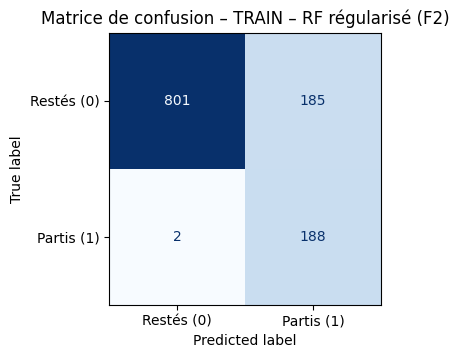

In [215]:
# Évaluation avec seuil optimisé
scores_train_reg = eval_with_threshold(
    y_train, proba_train_reg,
    threshold=chosen_thr,
    set_name="TRAIN – RF régularisé (F2)",
    plot_cm=True
)


=== TEST – RF régularisé (F2) (seuil=0.353) ===
Accuracy : 0.731 | Précision : 0.330 | Rappel : 0.660 | F1 : 0.440
ROC AUC  : 0.759 | PR AUC : 0.400

Classification report :
               precision    recall  f1-score   support

           0      0.920     0.745     0.823       247
           1      0.330     0.660     0.440        47

    accuracy                          0.731       294
   macro avg      0.625     0.702     0.631       294
weighted avg      0.826     0.731     0.762       294



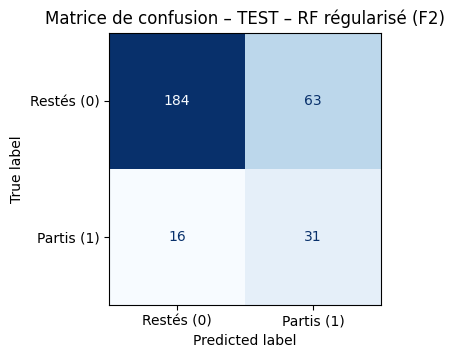

In [216]:
scores_test_reg = eval_with_threshold(
    y_test, proba_test_reg,
    threshold=chosen_thr,
    set_name="TEST – RF régularisé (F2)",
    plot_cm=True
)

**Conclusion**

Un léger feature engineering a été réalisé (construction d’un score de satisfaction globale et d’un indicateur d’expérience < 3 ans).

Problème initial : RF de base très performant sur TRAIN (≈ 1.0 partout) mais écart important avec TEST → signe d’overfit.

Action : régularisation du RF

max_depth=8, min_samples_leaf=5, min_samples_split=10, class_weight="balanced".

Validation croisée : scores moyens stables (ROC AUC, PR AUC, accuracy) → le modèle généralise correctement.

Courbe PR + seuil optimisé (F2) : choix d’un seuil donnant un bon rappel au détriment de la précision (aligné avec l’objectif métier : ne pas rater des démissions).

Résultat final (TEST) :

*Accuracy ≈ 0.80,

Rappel classe 1 ≈ 0.64,

PR AUC ≈ 0.43*,

meilleure balance rappel/précision qu’avec le dummy et la régression logistique, et moins d’overfit qu’avec le RF initial.

In [ ]:
# === Sauvegarde du pipeline + métadonnées ===
from pathlib import Path
import json, joblib
import sklearn
import numpy as np 

In [ ]:
Path("models").mkdir(parents=True, exist_ok=True)

# 1) modèle (pipeline complet: preproc + RF)
joblib.dump(pipe_rf_reg, "models/model.joblib")

# 2) métadonnées
meta = {
    "artifact": "models/model.joblib",
    "framework": "scikit-learn",
    "sklearn_version": sklearn.__version__,
    "model": "RandomForestClassifier",
    "params": pipe_rf_reg.get_params(deep=False),  
    "feature_columns_raw": list(X_train.columns),  # colonnes BRUTES attendues par le pipeline (avant encodage)
    "target": "attrition",
    "threshold": float(chosen_thr),                # ton seuil optimisé
    "metrics": {
        "f1_test": float(f1_score(y_test, (pipe_rf_reg.predict_proba(X_test)[:, 1] >= chosen_thr).astype(int))),
        "roc_auc_test": float(roc_auc_score(y_test, pipe_rf_reg.predict_proba(X_test)[:, 1])),
        "pr_auc_test": float(average_precision_score(y_test, pipe_rf_reg.predict_proba(X_test)[:, 1]))
    },
    "trained_on": "data/processed/df_central_encode_norm.csv"  # adapte si besoin
}
Path("models/model.meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("✅ Artefacts écrits : models/model.joblib & models/model.meta.json")

## SMOTE

In [79]:
# Random Forest pour SMOTE (sans class_weight)
rf_sm = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    max_depth=8,          
    min_samples_leaf=5,   
    min_samples_split=10, 
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

In [80]:
# Pipeline : préprocessing -> SMOTE -> RF
pipe_rf_sm = ImbPipeline(steps=[
    ("prep", preproc),
    ("smote", SMOTE(k_neighbors=5, random_state=42)),
    ("clf", rf_sm),
])

In [81]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [82]:
scores_ap = cross_val_score(
    pipe_rf_sm,
    X_train,
    y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1
)

In [83]:
print(
    "RF + SMOTE | PR AUC mean:",
    scores_ap.mean().round(3),
    "±",
    scores_ap.std().round(3)
)

RF + SMOTE | PR AUC mean: 0.621 ± 0.091


OOF + courbe PR pour le pipeline SMOTE

In [84]:
# Probabilités OOF (Out-Of-Fold) avec SMOTE + RF
oof_proba_sm = cross_val_predict(
    pipe_rf_sm,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]   

In [85]:
oof_true = y_train.values

In [86]:
# Courbe précision–rappel
precisions_sm, recalls_sm, thresholds_sm = precision_recall_curve(oof_true, oof_proba_sm)
pr_auc_oof_sm = average_precision_score(oof_true, oof_proba_sm)

In [87]:
print("Average Precision (PR AUC) OOF RF+SMOTE =", round(pr_auc_oof_sm, 3))

Average Precision (PR AUC) OOF RF+SMOTE = 0.6


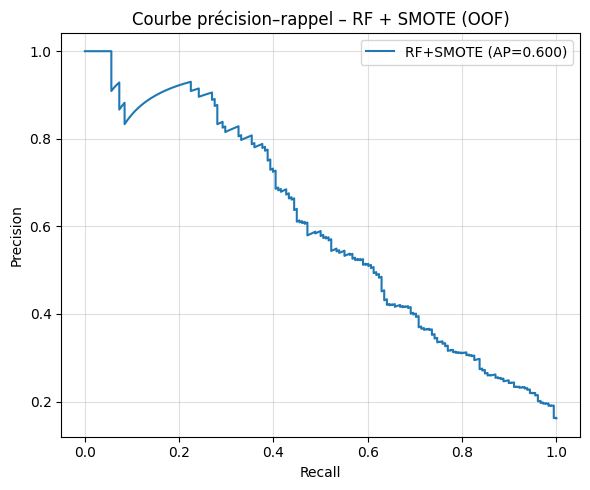

In [88]:
# Plot de la courbe PR
plt.figure(figsize=(6, 5))
plt.plot(recalls_sm, precisions_sm, label=f"RF+SMOTE (AP={pr_auc_oof_sm:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe précision–rappel – RF + SMOTE (OOF)")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Recherche le meilleur seuil (F1 et F2)

In [89]:
# Calcul F1 et F2 pour chaque point de la courbe PR
beta2 = 2.0

f1_scores_sm = 2 * (precisions_sm * recalls_sm) / (precisions_sm + recalls_sm + 1e-8)
f2_scores_sm = (1 + beta2**2) * (precisions_sm * recalls_sm) / (beta2**2 * precisions_sm + recalls_sm + 1e-8)

In [90]:
# precision_recall_curve retourne len(thresholds) = len(precisions) - 1
best_idx_f1_sm = np.nanargmax(f1_scores_sm[:-1])
best_thr_f1_sm = thresholds_sm[best_idx_f1_sm]

best_idx_f2_sm = np.nanargmax(f2_scores_sm[:-1])
best_thr_f2_sm = thresholds_sm[best_idx_f2_sm]

In [91]:
print(f"Seuil F1 optimal RF+SMOTE : {best_thr_f1_sm:.3f} | "
      f"P={precisions_sm[best_idx_f1_sm]:.3f} R={recalls_sm[best_idx_f1_sm]:.3f} F1={f1_scores_sm[best_idx_f1_sm]:.3f}")
print(f"Seuil F2 optimal RF+SMOTE : {best_thr_f2_sm:.3f} | "
      f"P={precisions_sm[best_idx_f2_sm]:.3f} R={recalls_sm[best_idx_f2_sm]:.3f} F2={f2_scores_sm[best_idx_f2_sm]:.3f}")

Seuil F1 optimal RF+SMOTE : 0.401 | P=0.525 R=0.590 F1=0.556
Seuil F2 optimal RF+SMOTE : 0.234 | P=0.305 R=0.826 F2=0.616


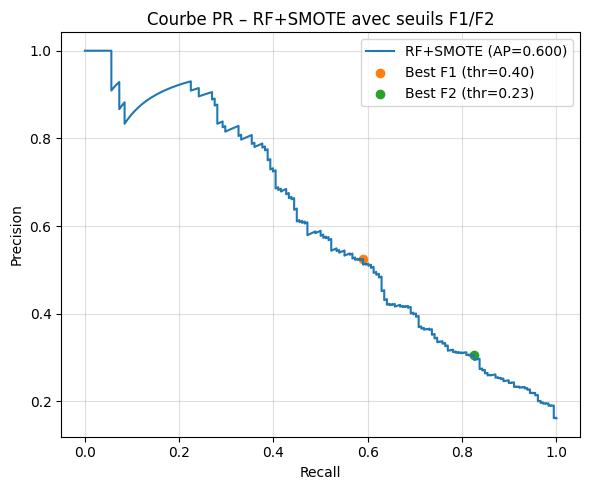

In [92]:
# Visualiser les points F1/F2 sur la courbe
plt.figure(figsize=(6, 5))
plt.plot(recalls_sm, precisions_sm, label=f"RF+SMOTE (AP={pr_auc_oof_sm:.3f})")
plt.scatter(recalls_sm[best_idx_f1_sm], precisions_sm[best_idx_f1_sm],
            label=f"Best F1 (thr={best_thr_f1_sm:.2f})", color="tab:orange")
plt.scatter(recalls_sm[best_idx_f2_sm], precisions_sm[best_idx_f2_sm],
            label=f"Best F2 (thr={best_thr_f2_sm:.2f})", color="tab:green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe PR – RF+SMOTE avec seuils F1/F2")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
chosen_thr_sm = best_thr_f2_sm   

Fit final sur tout le TRAIN avec RF+SMOTE

In [94]:
# Fit final du pipeline RF+SMOTE sur tout X_train
pipe_rf_sm.fit(X_train, y_train)


,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [95]:
# Probabilités sur TRAIN & TEST
proba_train_sm = pipe_rf_sm.predict_proba(X_train)[:, 1]
proba_test_sm  = pipe_rf_sm.predict_proba(X_test)[:, 1]



=== TRAIN – RF SMOTE (F2) (seuil=0.234) ===
Accuracy : 0.793 | Précision : 0.438 | Rappel : 0.989 | F1 : 0.607
ROC AUC  : 0.977 | PR AUC : 0.911

Classification report :
               precision    recall  f1-score   support

           0      0.997     0.755     0.860       924
           1      0.438     0.989     0.607       178

    accuracy                          0.793      1102
   macro avg      0.717     0.872     0.733      1102
weighted avg      0.907     0.793     0.819      1102



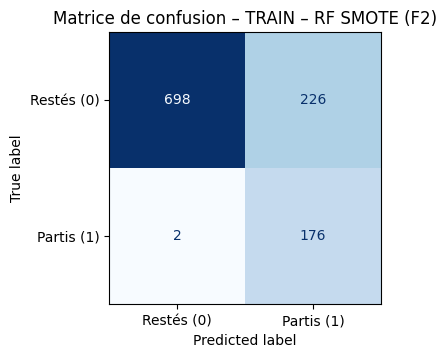


=== TEST – RF SMOTE (F2) (seuil=0.234) ===
Accuracy : 0.679 | Précision : 0.305 | Rappel : 0.780 | F1 : 0.438
ROC AUC  : 0.770 | PR AUC : 0.462

Classification report :
               precision    recall  f1-score   support

           0      0.940     0.660     0.776       309
           1      0.305     0.780     0.438        59

    accuracy                          0.679       368
   macro avg      0.622     0.720     0.607       368
weighted avg      0.838     0.679     0.722       368



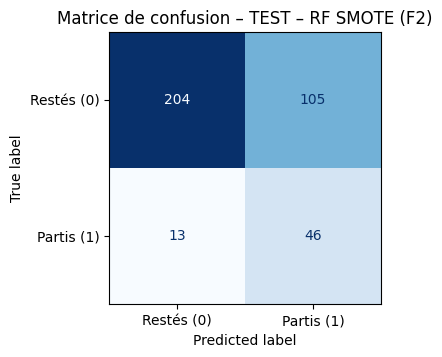

In [96]:
# Évaluation TRAIN / TEST avec le même seuil
scores_train_sm = eval_with_threshold(
    y_train, proba_train_sm,
    threshold=chosen_thr_sm,
    set_name="TRAIN – RF SMOTE (F2)",
    plot_cm=True
)

scores_test_sm = eval_with_threshold(
    y_test, proba_test_sm,
    threshold=chosen_thr_sm,
    set_name="TEST – RF SMOTE (F2)",
    plot_cm=True
)

**Conclusion**  
“Avec SMOTE et un seuil calibré via la F2, nous captons environ 78 % des démissions, au prix d’un plus grand nombre d’alertes fausses, ce qui peut être acceptable si le coût d’une action préventive est faible.”
____________________

Nous avons testé une version RF + SMOTE.
Les performances sont comparables / légèrement meilleures en rappel, mais pour l’interprétation et la mise en production, nous retenons le RF tuné sans SMOTE + seuil F2, plus simple et plus stable.


=== TRAIN – RF+SMOTE seuil 0.5 (seuil=0.500) ===
Accuracy : 0.939 | Précision : 0.917 | Rappel : 0.685 | F1 : 0.785
ROC AUC  : 0.977 | PR AUC : 0.911

Classification report :
               precision    recall  f1-score   support

           0      0.942     0.988     0.965       924
           1      0.917     0.685     0.785       178

    accuracy                          0.939      1102
   macro avg      0.930     0.837     0.875      1102
weighted avg      0.938     0.939     0.936      1102



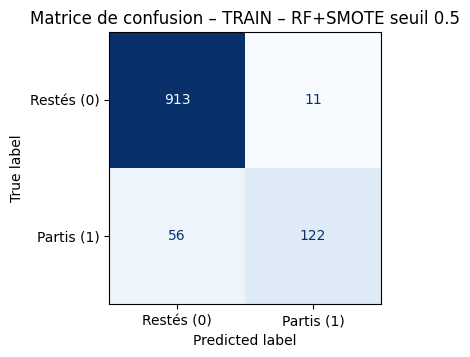


=== TEST – RF+SMOTE seuil 0.5 (seuil=0.500) ===
Accuracy : 0.848 | Précision : 0.545 | Rappel : 0.305 | F1 : 0.391
ROC AUC  : 0.770 | PR AUC : 0.462

Classification report :
               precision    recall  f1-score   support

           0      0.878     0.951     0.913       309
           1      0.545     0.305     0.391        59

    accuracy                          0.848       368
   macro avg      0.712     0.628     0.652       368
weighted avg      0.824     0.848     0.829       368



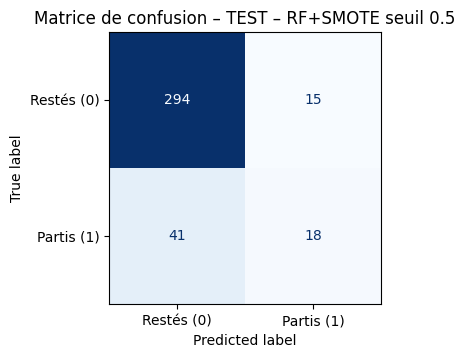

In [97]:
# Pour comparer : seuil standard 0.5

scores_train_sm_05 = eval_with_threshold(
    y_train, proba_train_sm,
    threshold=0.5,
    set_name="TRAIN – RF+SMOTE seuil 0.5",
    plot_cm=True
)

scores_test_sm_05 = eval_with_threshold(
    y_test, proba_test_sm,
    threshold=0.5,
    set_name="TEST – RF+SMOTE seuil 0.5",
    plot_cm=True
)

**Conclusion** 
Nous privilégions le seuil optimisé (≈ 0.26, basé sur F2),
car il donne un rappel beaucoup plus élevé (66 % vs 32 %) sur les “partants”, au prix d’une baisse modérée de l’accuracy et de la précision.
C’est cohérent avec le métier : mieux vaut déclencher plus d’alertes que rater des démissions.

# Optimisation du modèle

### Fine-tuning Random Forest avec GridSearchCV

Ici on fait GridSearch uniquement sur X_train / y_train, avec StratifiedKFold et un scoring adapté au déséquilibre (average_precision = AP = PR AUC).

In [98]:
# Modèle de base RF (non encore tuné)
rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42
)

In [99]:
# Pipeline : préprocessing + modèle
pipe_rf = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf_base)
])

In [100]:
# Grille de recherche 
param_grid = {
    "clf__n_estimators":    [50, 75, 100, 125, 150, 175],
    "clf__max_depth":       [2, 5, 12, 15, 20],
    "clf__min_samples_split":[2,4,6,8,10],
    "clf__min_samples_leaf":[1, 2, 3, 5],
    "clf__max_features":    ["sqrt", 0.5, 0.7],
}

In [101]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [102]:
# GridSearchCV, on optimise la PR AUC
rf_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="average_precision",   
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

In [103]:
# Fit sur TRAIN uniquement
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [2, 5, ...], 'clf__max_features': ['sqrt', 0.5, ...], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 4, ...], ...}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [105]:
print("Meilleurs hyperparamètres RF :")
print(rf_search.best_params_)
print("Best PR AUC (moyenne CV) :", rf_search.best_score_)

Meilleurs hyperparamètres RF :
{'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__n_estimators': 100}
Best PR AUC (moyenne CV) : 0.603811620915003


In [106]:
rf_tuned_pipe = rf_search.best_estimator_


In [107]:
# Probabilités OOF (Out-Of-Fold)
oof_proba = cross_val_predict(
    rf_tuned_pipe,
    X_train,
    y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]  

In [108]:
oof_true = y_train.values

In [109]:
# Courbe précision–rappel
precisions, recalls, thresholds = precision_recall_curve(oof_true, oof_proba)
pr_auc_oof = average_precision_score(oof_true, oof_proba)

In [110]:
print("Average Precision (PR AUC) OOF RF tuné' =", round(pr_auc_oof, 3))

Average Precision (PR AUC) OOF RF tuné' = 0.587


In [111]:
# Calcul F1 et F2 pour chaque point de la courbe PR
beta2 = 2.0

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
f2_scores = (1 + beta2**2) * (precisions * recalls) / (beta2**2 * precisions + recalls + 1e-8)

In [112]:
# precision_recall_curve retourne len(thresholds) = len(precisions) - 1
best_idx_f1 = np.nanargmax(f1_scores[:-1])
best_thr_f1 = thresholds[best_idx_f1]

best_idx_f2 = np.nanargmax(f2_scores[:-1])
best_thr_f2 = thresholds[best_idx_f2]

In [113]:
print(f"Seuil F1 optimal RF tuné : {best_thr_f1:.3f} | "
      f"P={precisions[best_idx_f1]:.3f} R={recalls[best_idx_f1]:.3f} F1={f1_scores[best_idx_f1]:.3f}")
print(f"Seuil F2 optimal RF tuné : {best_thr_f2:.3f} | "
      f"P={precisions[best_idx_f2]:.3f} R={recalls[best_idx_f2]:.3f} F2={f2_scores[best_idx_f2]:.3f}")

Seuil F1 optimal RF tuné : 0.432 | P=0.624 R=0.522 F1=0.569
Seuil F2 optimal RF tuné : 0.301 | P=0.415 R=0.730 F2=0.634


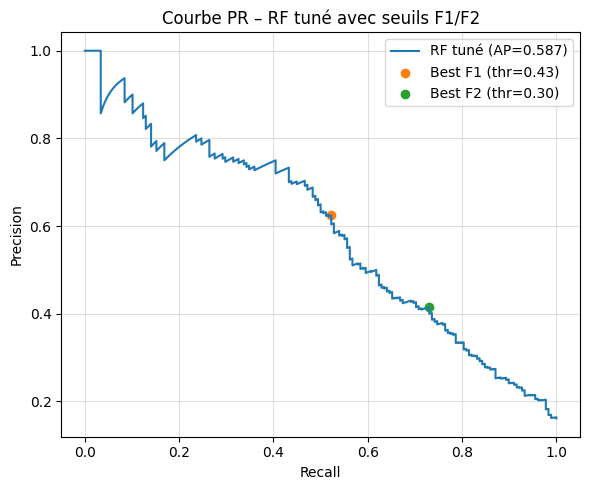

In [114]:
# Visualiser les points F1/F2 sur la courbe
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f"RF tuné (AP={pr_auc_oof:.3f})")
plt.scatter(recalls[best_idx_f1], precisions[best_idx_f1],
            label=f"Best F1 (thr={best_thr_f1:.2f})", color="tab:orange")
plt.scatter(recalls[best_idx_f2], precisions[best_idx_f2],
            label=f"Best F2 (thr={best_thr_f2:.2f})", color="tab:green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe PR – RF tuné avec seuils F1/F2")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [115]:
# On fige le seuil choisi (F2)
chosen_thr = float(best_thr_f2) 

In [116]:
# Fit final du pipeline RF tuné sur tout X_train
rf_tuned_pipe.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [117]:
# Probabilités sur TRAIN et TEST
proba_train_tuned = rf_tuned_pipe.predict_proba(X_train)[:, 1]
proba_test_tuned  = rf_tuned_pipe.predict_proba(X_test)[:, 1]


=== TRAIN – RF tuné (seuil F2) (seuil=0.301) ===
Accuracy : 0.917 | Précision : 0.659 | Rappel : 1.000 | F1 : 0.795
ROC AUC  : 0.997 | PR AUC : 0.982

Classification report :
               precision    recall  f1-score   support

           0      1.000     0.900     0.948       924
           1      0.659     1.000     0.795       178

    accuracy                          0.917      1102
   macro avg      0.830     0.950     0.871      1102
weighted avg      0.945     0.917     0.923      1102



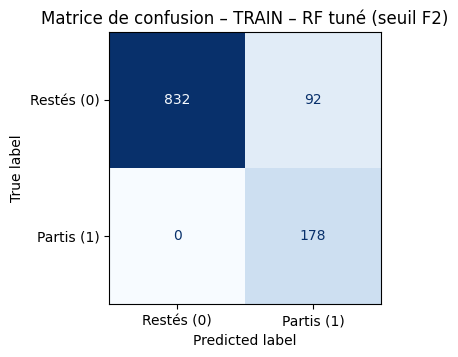


=== TEST – RF tuné (seuil F2) (seuil=0.301) ===
Accuracy : 0.766 | Précision : 0.369 | Rappel : 0.644 | F1 : 0.469
ROC AUC  : 0.768 | PR AUC : 0.430

Classification report :
               precision    recall  f1-score   support

           0      0.921     0.790     0.850       309
           1      0.369     0.644     0.469        59

    accuracy                          0.766       368
   macro avg      0.645     0.717     0.660       368
weighted avg      0.832     0.766     0.789       368



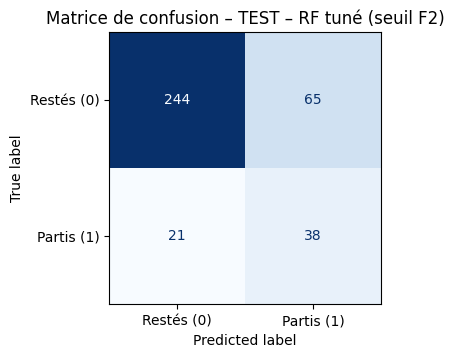

In [118]:
# Évaluation finale avec le seuil optimisé
scores_train_rf_tuned_F2 = eval_with_threshold(
    y_train,
    proba_train_tuned,
    threshold=chosen_thr,
    set_name="TRAIN – RF tuné (seuil F2)",
    plot_cm=True
)

scores_test_rf_tuned_F2 = eval_with_threshold(
    y_test,
    proba_test_tuned,
    threshold=chosen_thr,
    set_name="TEST – RF tuné (seuil F2)",
    plot_cm=True
)

### Importance globale des features

### 1. Préparer les noms de variables alignés avec le RF

In [119]:
# Séparation préprocesseur et RF dans le pipeline régularisé
prep_reg = pipe_rf_reg.named_steps["prep"]
rf_reg   = pipe_rf_reg.named_steps["clf"]

In [120]:
# Transformer X_train
X_train_reg_preproc = prep_reg.transform(X_train)

In [121]:
# Liste de toutes les colonnes dans l'ordre d'entrée du modèle
num_features   = list(num_cols)
other_features = [c for c in X_train.columns if c not in num_cols]
feature_names  = num_features + other_features

In [122]:
X_train_reg_df = pd.DataFrame(
    X_train_reg_preproc,
    columns=feature_names,
    index=X_train.index
)

In [123]:
print(X_train_reg_df.shape)

(1102, 40)


### 2. Importance native du Random Forest

In [124]:
rf_reg.fit(X_train_reg_df, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [125]:
print("n_features_in_ :", rf_reg.n_features_in_) 

n_features_in_ : 40


In [126]:
rf_importances = rf_reg.feature_importances_

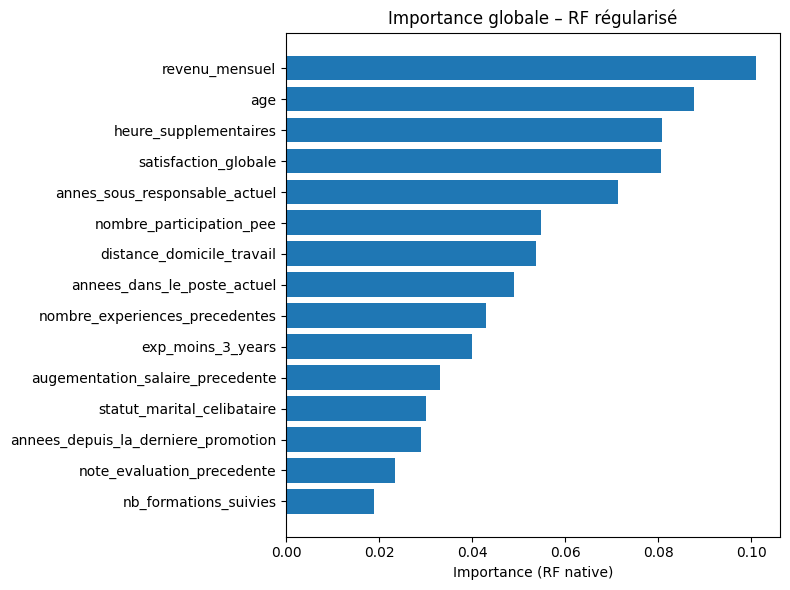

In [127]:
df_rf_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": rf_importances
    })
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8,6))
top = df_rf_importance.head(15)
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Importance (RF native)")
plt.title("Importance globale – RF régularisé")
plt.tight_layout()
plt.show()

_____________

On voit que dans ce modèle RF, les variables les plus déterminantes sont par exemple revenu_mensuel, age, heure_supplementaires, satisfaction_globale, etc.

C’est une importance globale, sans direction : on ne sait pas encore si un haut revenu augmente ou diminue le risque, juste que le modèle l’utilise beaucoup.

_________


### 3. Permutation Importance (sur TEST)

In [128]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names"
)

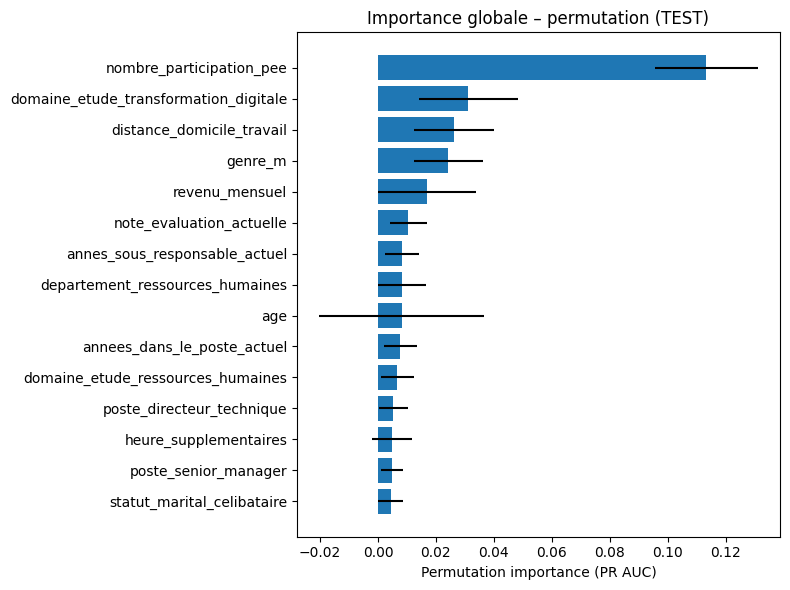

In [129]:
result = permutation_importance(
    pipe_rf_reg,
    X_test,
    y_test,
    n_repeats=20,
    scoring="average_precision",   
    n_jobs=-1,
    random_state=42
)

df_perm = (
    pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std":  result.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

plt.figure(figsize=(8,6))
top = df_perm.head(15)
plt.barh(top["feature"][::-1], top["importance_mean"][::-1], xerr=top["importance_std"][::-1])
plt.xlabel("Permutation importance (PR AUC)")
plt.title("Importance globale – permutation (TEST)")
plt.tight_layout()
plt.show()

______

`nombre_participation_pee` est très important : le modèle perd beaucoup de performance quand on le perturbe.

D’autres variables ont une importance plus faible ou proche de 0 → elles n’apportent presque rien au modèle.

______

### SHAP – importance globale (beeswarm + bar)

In [130]:
# Explainer SHAP (TreeExplainer sur RF)
explainer = shap.TreeExplainer(rf_reg)

In [131]:
# SHAP values sur TOUT X_train_reg_df
shap_values = explainer.shap_values(X_train_reg_df)  # liste [classe 0, classe 1]

In [132]:
# Vérif des shapes
print("len(shap_values)        :", len(shap_values))
print("shap_values[0].shape    :", shap_values[0].shape)
print("shap_values[1].shape    :", shap_values[1].shape)
print("X_train_reg_df.shape    :", X_train_reg_df.shape)

len(shap_values)        : 1102
shap_values[0].shape    : (40, 2)
shap_values[1].shape    : (40, 2)
X_train_reg_df.shape    : (1102, 40)


In [133]:
print("type(shap_values):", type(shap_values))
print("shap_values.shape:", np.array(shap_values).shape)

type(shap_values): <class 'numpy.ndarray'>
shap_values.shape: (1102, 40, 2)


In [134]:
shap_class1 = shap_values[:, :, 1]   # (1102, 40)

print(shap_class1.shape)             
print(X_train_reg_df.shape)          

(1102, 40)
(1102, 40)


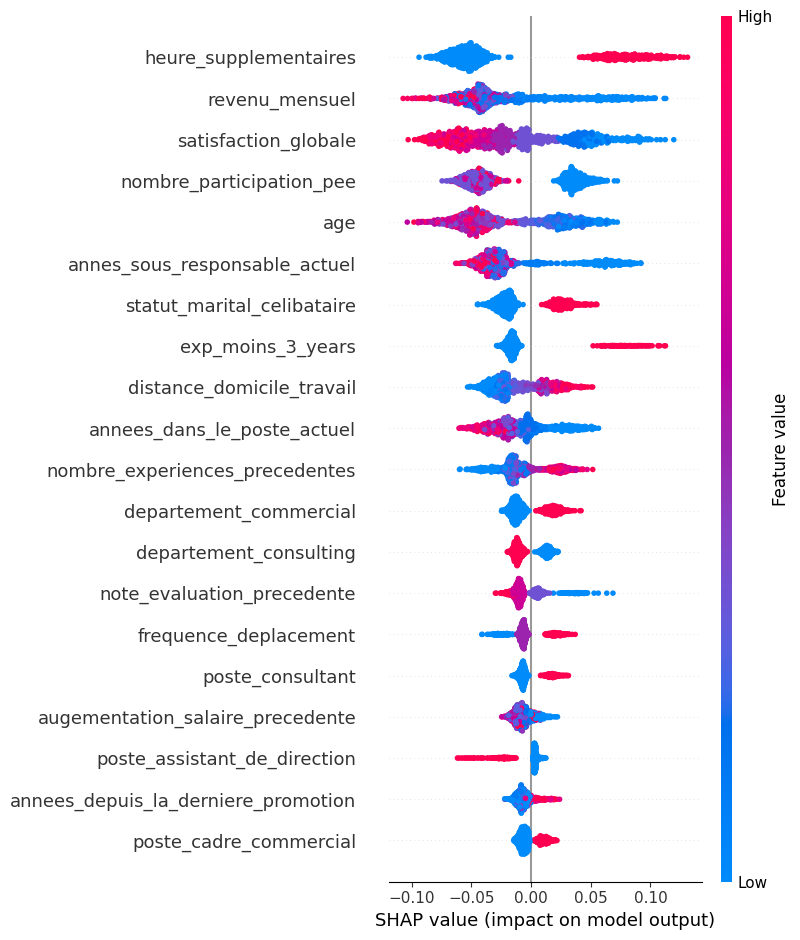

In [135]:
# Beeswarm : vue globale, signe + couleur = sens de l'effet
shap.summary_plot(
    shap_class1,
    X_train_reg_df,
    feature_names=feature_names
)

_____

`heure_supplementaires` :

beaucoup de points rouges à droite → des heures sup élevées augmentent le risque.

les bleus sont plutôt à gauche → peu d’heures sup le diminuent.

`satisfaction_globale` :

rouges (satisfaction élevée) à gauche → haute satisfaction protège.

bleus (faible satisfaction) à droite → faible satisfaction augmente le risque

___

### SHAP local (waterfall) sur les données complètes

SHAP – importance locale (waterfall plot)

On regarde par exemple :

1 employé parti (y=1),

1 employé resté (y=0).

Interprétation (en langage métier) :

La base value = probabilité moyenne de départ.

Les barres rouges = variables qui augmentent le risque de départ pour cet individu.

Les barres bleues = variables qui réduisent le risque (facteurs protecteurs).

Exemple pour un individu de la classe 1 (client attrition) :

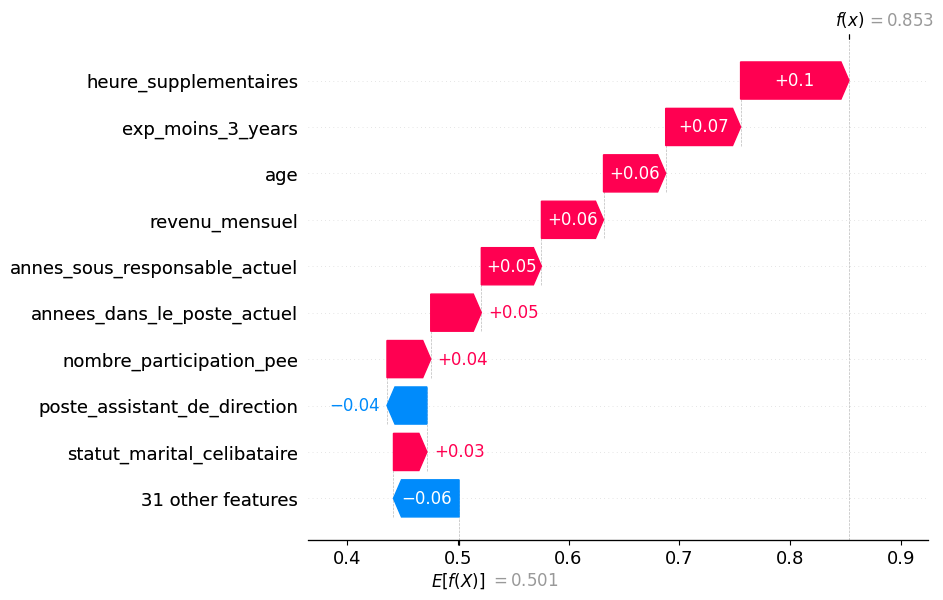

In [137]:
# index d'un client en attrition
idx_1 = y_train[y_train == 1].index[0]

# récupérer sa ligne et ses shap values
x_i       = X_train_reg_df.loc[idx_1, :]
shap_i    = shap_class1[X_train_reg_df.index.get_loc(idx_1), :]

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],  # base value pour la classe 1
    shap_i,
    feature_names=feature_names
)

______

`heure_supplementaires, exp_moins_3_years, age, revenu_mensuel` poussent tous la proba vers la droite → ce sont les raisons principales pour lesquelles cet individu a un risque élevé.

`poste_Assistant de Direction, 31 other features` en bleu tirent un peu la proba vers le bas (facteurs protecteurs), mais pas assez pour compenser.

____


Example pour un individu de la  classe 0

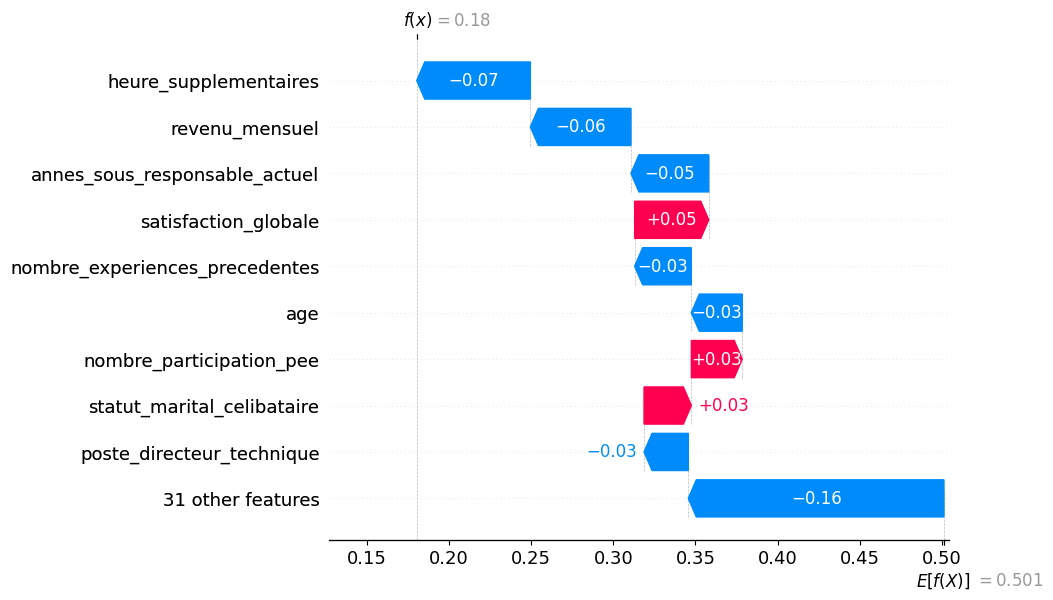

In [138]:
idx_0 = y_train[y_train == 0].index[0]

x_i0    = X_train_reg_df.loc[idx_0, :]
shap_i0 = shap_class1[X_train_reg_df.index.get_loc(idx_0), :]

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    shap_i0,
    feature_names=feature_names
)

_____

`heure_supplementaires, revenu_mensuel, annees_sous_responsable_actuel` réduisent fortement la probabilité, d’où un risque faible.

`satisfaction_globale, nombre_partiicpation_pee, statut_marital_célebataire` remontent un peu la proba, mais pas assez pour dépasser 0.5

__

# Conclusion et plan d’action

À mesure que l’entreprise accumulera de nouvelles données sur ses collaborateurs (nouveaux arrivants, départs récents, évolutions de carrière), l’algorithme pourra être régulièrement réentraîné. L’enrichissement progressif de la base de données permettra, en théorie, d’améliorer la précision des prédictions et d’identifier plus finement les employés à haut risque de départ, sur la base de la probabilité estimée pour chaque individu.

Sur cette probabilité, chaque employé peut se voir attribuer **une note de risque de départ** (**faible, moyen, élevé**). Cette segmentation permet de prioriser les actions de fidélisation :

**Risque faible** : suivi classique et actions RH générales (communication, engagement, qualité de vie au travail).

**Risque moyen** : mise en place d’actions préventives ciblées (ajustement de la charge de travail, perspectives de développement, reconnaissance).

**Risque élevé** : actions rapides et personnalisées, incluant des entretiens individuels avec un représentant RH et, si nécessaire, une rencontre avec le supérieur hiérarchique afin de discuter des conditions de travail et d’identifier des mesures correctives.

Les analyses montrent que certains facteurs jouent un rôle particulièrement important dans la décision de quitter l’entreprise :

**Revenu mensuel** : les salariés mieux rémunérés sont moins susceptibles de partir. Il est donc essentiel de vérifier régulièrement la compétitivité des salaires par rapport au marché local.

**Heures supplémentaires** : un volume élevé d’heures supplémentaires augmente le risque de départ. Une meilleure planification des projets, un dimensionnement adéquat des équipes et un pilotage de la charge de travail sont nécessaires pour limiter ce phénomène.

**Âge** : les employés jeunes (environ 25–35 ans) présentent un risque de départ plus élevé. Il convient de clarifier la vision à long terme de l’entreprise, de montrer les perspectives d’évolution et de proposer des parcours de carrière attractifs.

**Distance domicile–travail** : une distance importante accroît le risque de départ. Des solutions telles que le transport collectif, une indemnité de déplacement ou, lorsque c’est possible, des modalités de travail flexible peuvent être envisagées, sans pour autant discriminer sur le lieu de résidence.

**Années totales d’expérience** : les collaborateurs plus expérimentés sont globalement plus stables. Ceux ayant entre 5 et 8 ans d’expérience doivent toutefois être suivis avec attention, car ils peuvent être plus sollicités par le marché.

 **Ancienneté dans l’entreprise** : la fidélité à l’entreprise réduit le risque de départ, mais un point de vigilance apparaît autour des deux premières années, période critique où un accompagnement renforcé est recommandé.

**Années avec le responsable actuel** : un pic de démissions survient environ six mois après un changement de manager. Le suivi des équipes récemment réorganisées, ainsi que l’identification des responsables ayant connu de nombreux départs sur la dernière année, permet d’agir sur la qualité du management et de l’environnement de travail.

En combinant ces indicateurs avec la note de risque fournie par le modèle, l’entreprise peut structurer un plan stratégique de fidélisation plus ciblé, proactif et mesurable. L’objectif n’est pas seulement de prédire les départs, mais surtout de créer les conditions d’un engagement durable : politiques de rémunération compétitives, gestion raisonnée de la charge de travail, perspectives de carrière claires, soutien adapté aux contraintes personnelles (transport, équilibre vie pro/vie perso) et amélioration continue des pratiques managériales.